### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest', 'SVM_poly', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].transform(impute_mean)

In [8]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
#               'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
#               'pfeffer_total','cognition', 'functionality', 'marital_status', 'n_children',
#               'household_members', 'household_income', 'Job_status', 'strata']

final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
              'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs',
              'functionality', 'marital_status', 'n_children', 'household_members', 'household_income',
              'Job_status', 'strata']


train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [9]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'moca_vs', 'ace_vs', 'functionality', 'marital_status',
       'n_children', 'household_members', 'household_income', 'Job_status',
       'strata'],
      dtype='object')

In [10]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 17), (161, 17))

In [11]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [12]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop
hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-12/mean_hparams/"


rf_hp = pd.read_csv(hparams_path + "RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_colsample_bytree','param_min_child_weight',
        'params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [13]:
rf_row = 0
rf_hp.iloc[rf_row,:]

param_criterion                                                         gini
param_max_depth                                                            5
param_max_features                                                        10
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       309
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.872814
mean_train_score                                                    0.944521
Name: 0, dtype: object

In [14]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      3.208079
param_coef0                                                       100
param_degree                                                        2
param_gamma                                                  0.659135
params              OrderedDict([('C', 3.208079260205241), ('coef0...
mean_test_score                                              0.828492
mean_train_score                                             0.884649
Name: 0, dtype: object

In [15]:
xgb_row=0
xgb_hp.iloc[0, :]

param_colsample_bytree                                                  1.0
param_learning_rate                                                0.204802
param_max_depth                                                           7
param_min_child_weight                                                   15
param_n_estimators                                                     1000
params                    OrderedDict([('colsample_bytree', 1.0), ('eval...
mean_test_score                                                    0.845185
mean_train_score                                                   0.907781
Name: 0, dtype: object

In [16]:
## Models Hparams
# RF
rf_params= {"n_estimators": 500,#rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":15,#rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0, 'max_iter':10**6}

#XGBOOST
xgb_params = {
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'colsample_bytree': xgb_hp.loc[xgb_row, 'param_colsample_bytree'],
    'min_child_weight': xgb_hp.loc[xgb_row, 'param_min_child_weight'],
    'gamma': 1,
    'subsample':1.0,
#     'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

# xgb_params ={'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.8045117829208245,
#              'learning_rate': 0.06547359028644324, 'max_depth': 4, 'n_estimators': 100,
#              'objective': 'binary:logistic', 'reg_alpha': 0.0, 'reg_lambda': 0.9798465147079346,
#              'subsample': 0.8,'n_jobs': -1,'verbosity':0}

In [17]:
n_iter = 5000

### Base model: Logistic Regression

In [18]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:14<00:00, 25.68it/s]


singular_matrix_errors (droped from results): 0
Eleapsed time:3.2457640012105307 minutes
empirical p-value: 0.0


In [19]:
lr_res.mean()

Accuracy         0.810061
ROC_AUC          0.814842
Precision        0.762147
Recall           0.287752
Sensitivity      0.287752
Specificity      0.971310
F1               0.414016
Efron_pR2        0.238466
mcfadden_pR2     0.313722
mcfadden_apR2    0.255527
dtype: float64

In [20]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.010873,0.010767,0.011802,0.012549,0.012549,0.004627,0.013653,0.011812,0.012862,0.01209


In [21]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,-0.353809,0.160444,-2.251856,1.030170,0.131768,0.190857
1,ace_vs,0.941518,0.162132,1.598830,0.301657,0.227231,0.027083
2,functionality,0.082583,0.205834,0.375568,0.944032,0.971741,0.029210
3,household_income,-0.418446,0.179467,-1.560140,0.684961,0.302557,0.167317
4,household_members,-0.233561,0.152139,-0.500267,0.335886,0.988584,0.001948


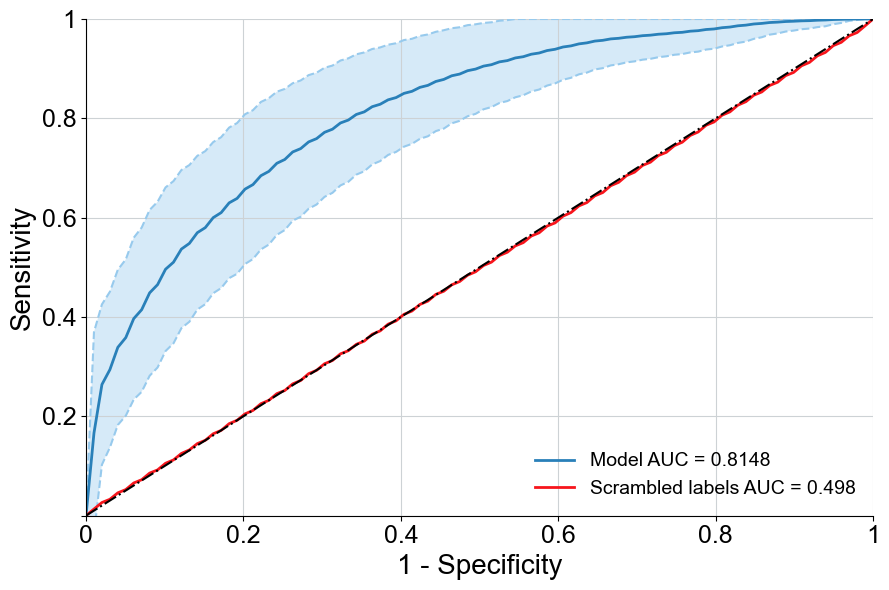

In [22]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [23]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [24]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

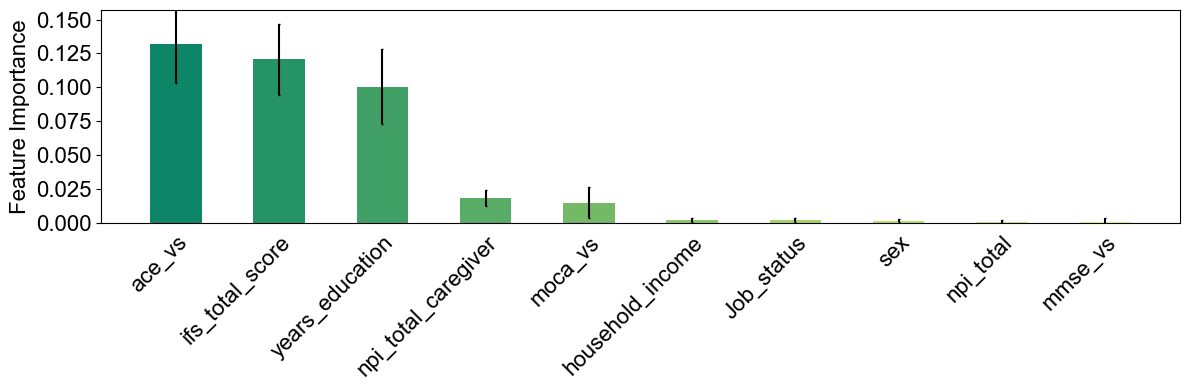

In [25]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

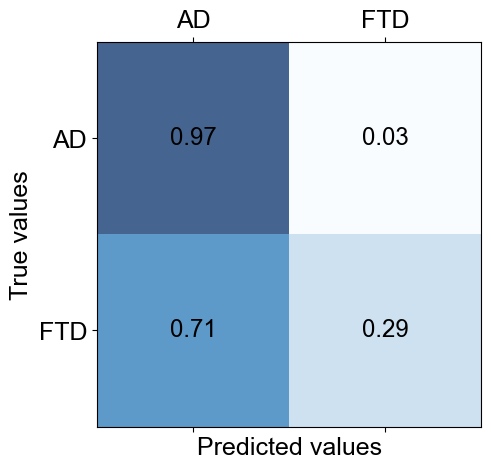

In [26]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [27]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [28]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [29]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [30]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [31]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5817
Accuracy: 0.785
Recall: 0.2
F1: 0.303
Precision:0.625


In [32]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5817
Bootstrping test ROC score: 	0.8148


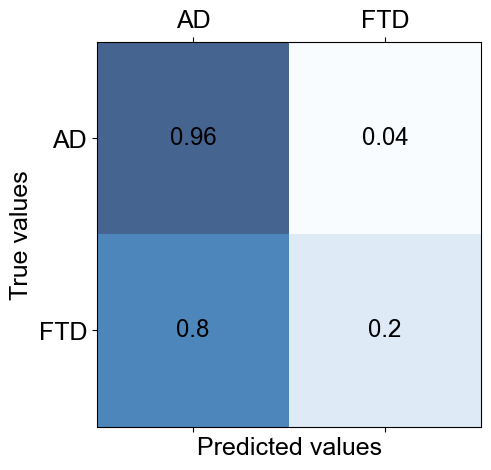

In [33]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'])

### RF Model

##### Bootstrap

In [34]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=15,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:21:26<00:00,  1.02it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:81.43460440238317 minutes
empirical p-value: 0.0


In [35]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-12-05/mean_res'

In [36]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.805155
ROC_AUC        0.864939
Precision      0.569481
Recall         0.738387
Sensitivity    0.738387
Specificity    0.825768
F1             0.641236
Efron_pR2      0.240165
dtype: float64

In [37]:
print("%.4f" % Model_res['ROC_AUC'].mean())

0.8649


In [38]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010979,0.009474,0.013725,0.012183,0.012183,0.010514,0.013295,0.011841


In [39]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
14,year_birth,0.319629,0.039248
5,ifs_total_score,0.241067,0.030689
1,ace_vs,0.101762,0.022517
15,years_education,0.073344,0.016384
11,npi_total,0.038447,0.008664
9,moca_vs,0.029575,0.008012
3,household_income,0.029348,0.008623
6,marital_status,0.028682,0.009398
2,functionality,0.027780,0.005924
0,Job_status,0.024892,0.006659


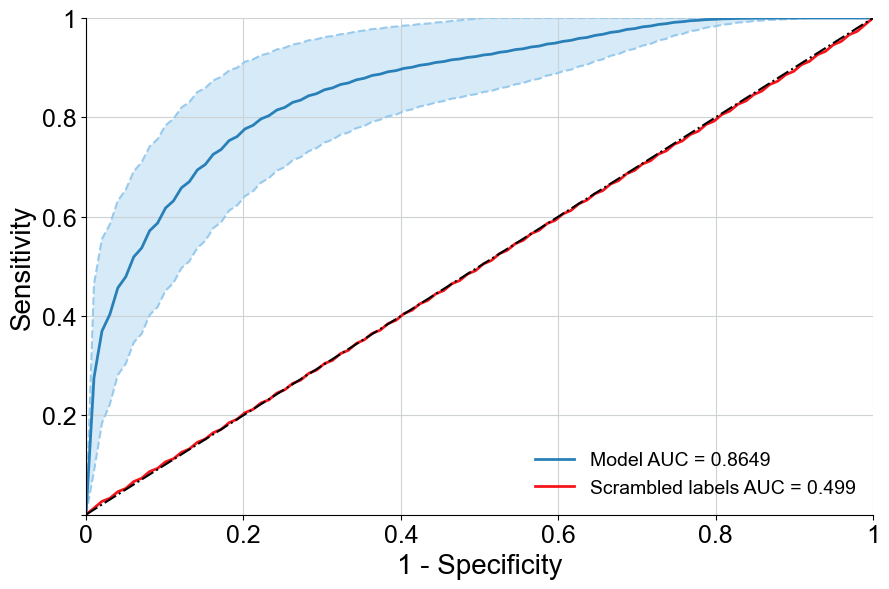

In [40]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")

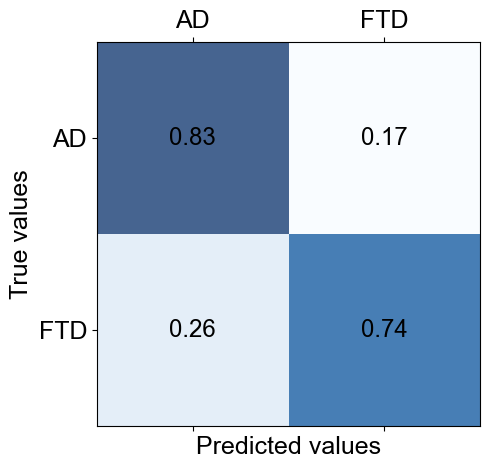

In [41]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [42]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [43]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [44]:
top_10p.head()

,predictor,mean,std
3,ifs_total_score,0.114032,0.024115
0,year_birth,0.102805,0.028939
2,years_education,0.015160,0.004439
9,ace_vs,0.014067,0.009317
5,npi_total,0.009680,0.005258


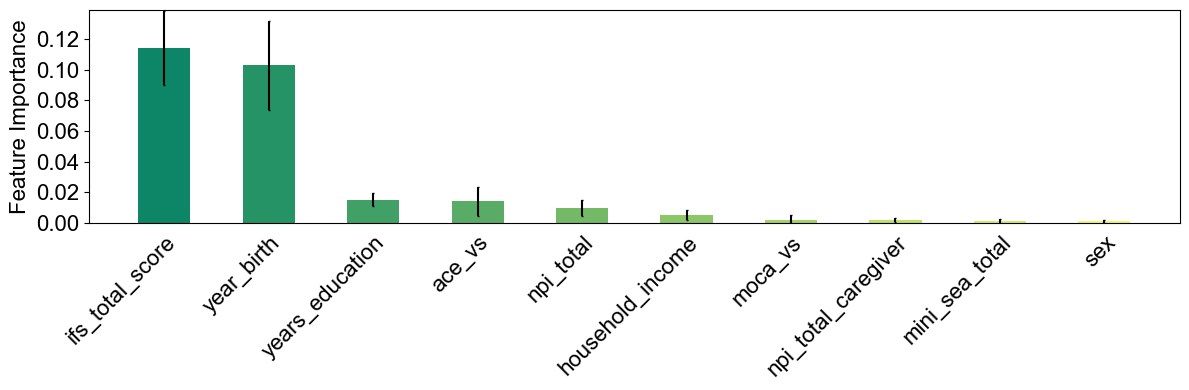

In [45]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [46]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
14,year_birth,0.319629,0.039248
5,ifs_total_score,0.241067,0.030689
1,ace_vs,0.101762,0.022517
15,years_education,0.073344,0.016384
11,npi_total,0.038447,0.008664


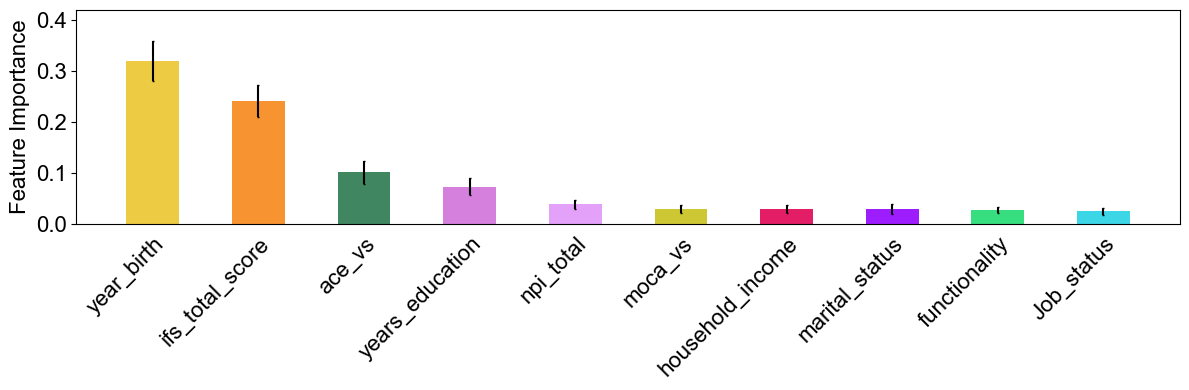

In [47]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [48]:
# X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
# X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [49]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [50]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [51]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.839
Accuracy: 0.8598
Recall: 0.8
F1: 0.7273
Precision:0.6667


In [52]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.839
Bootstrping test ROC score: 	0.8649


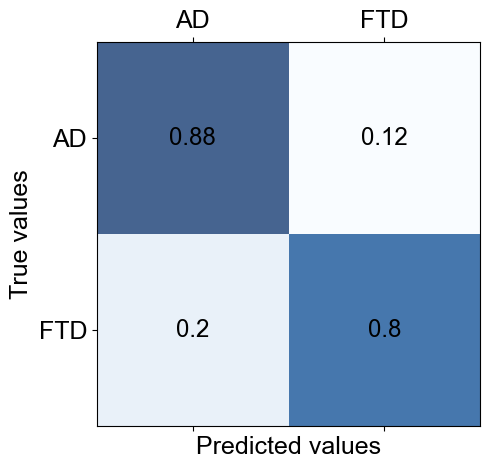

In [53]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM_unseen.png")

#### Shapley

In [54]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

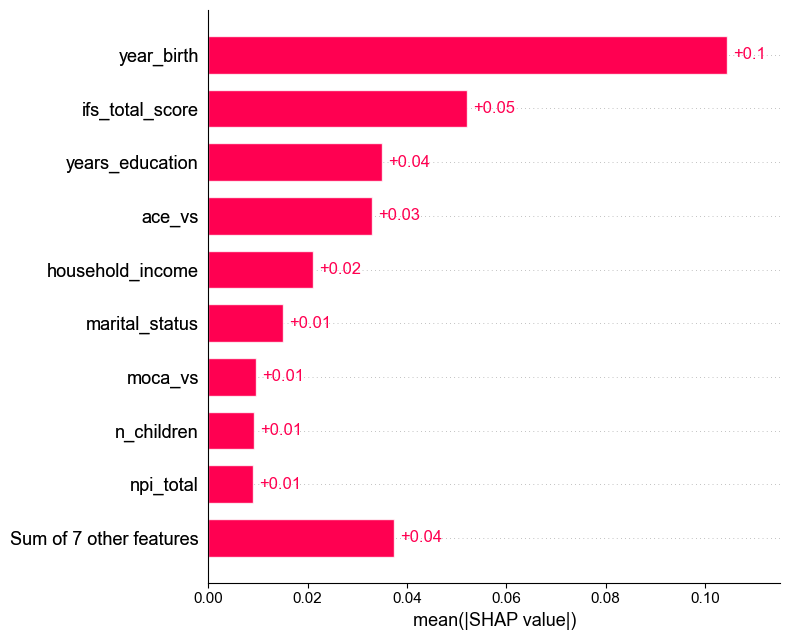

In [55]:
shap.plots.bar(shap_values[:,:,1])

In [56]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [57]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [58]:
# shap.summary_plot(shap_values2[:,:,1])

In [59]:
# shap.plots.bar(shap_values2[:,:,1])

In [60]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [61]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [175]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=3.208079260205241, class_weight='balanced', coef0=100, degree=2,
    gamma=0.6591346153501173, kernel='poly', max_iter=1000000, verbose=0)


Iterating: 100%|██████████████████| 5000/5000 [12:18<00:00,  6.77it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:12.312714195251464 minutes
empirical p-value: 0.0


In [176]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.769343
ROC_AUC        0.761548
Precision      0.509635
Recall         0.746791
Sensitivity    0.746791
Specificity    0.776305
F1             0.604456
dtype: float64

In [177]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.011677
ROC_AUC_ci        0.011812
Precision_ci      0.013857
Recall_ci         0.012053
Sensitivity_ci    0.012053
Specificity_ci    0.011551
F1_ci             0.013553
dtype: float64

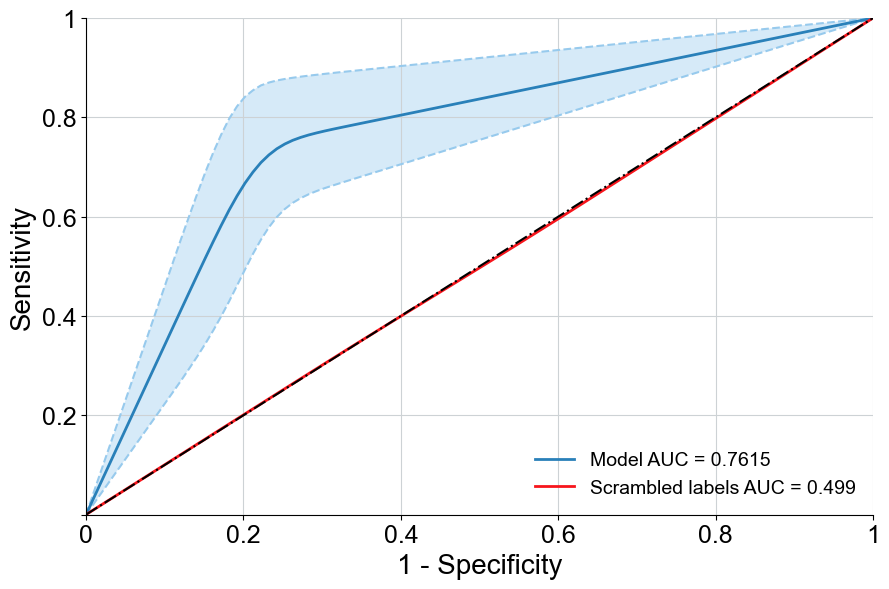

In [178]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

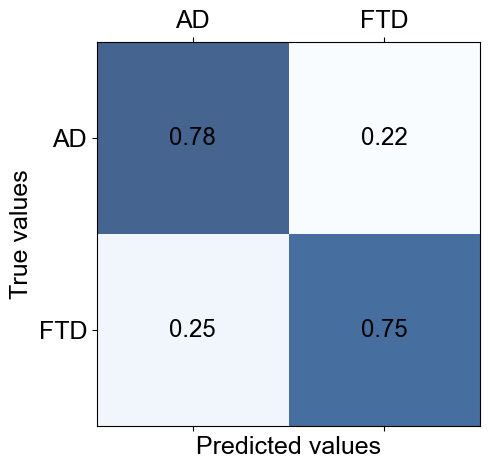

In [179]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [180]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


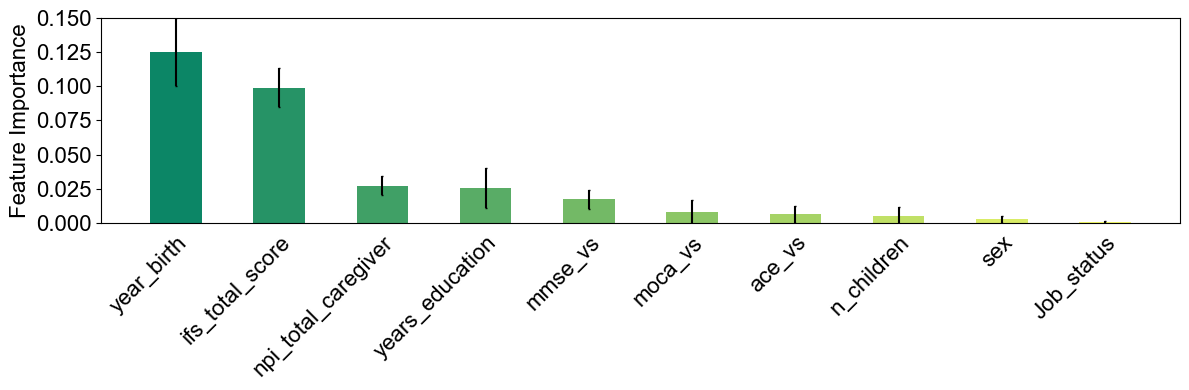

In [181]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [182]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [183]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [184]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.8146
Accuracy: 0.8224
Recall: 0.8
F1: 0.678
Precision:0.5882

Unseen Data ROC score: 		0.8146
Bootstrping test ROC score: 	0.7615


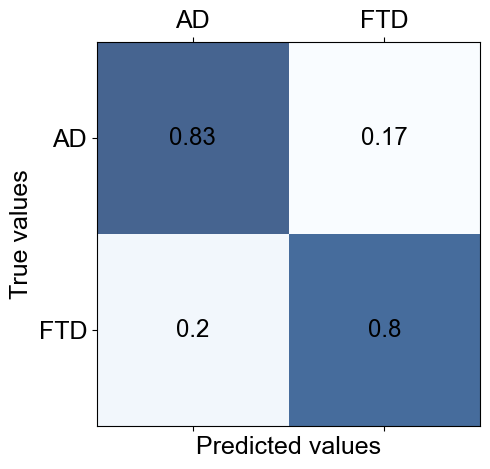

In [185]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_PFI_unseen.png")

#### Shapley

In [186]:
poly_params['probability'] = True

In [187]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

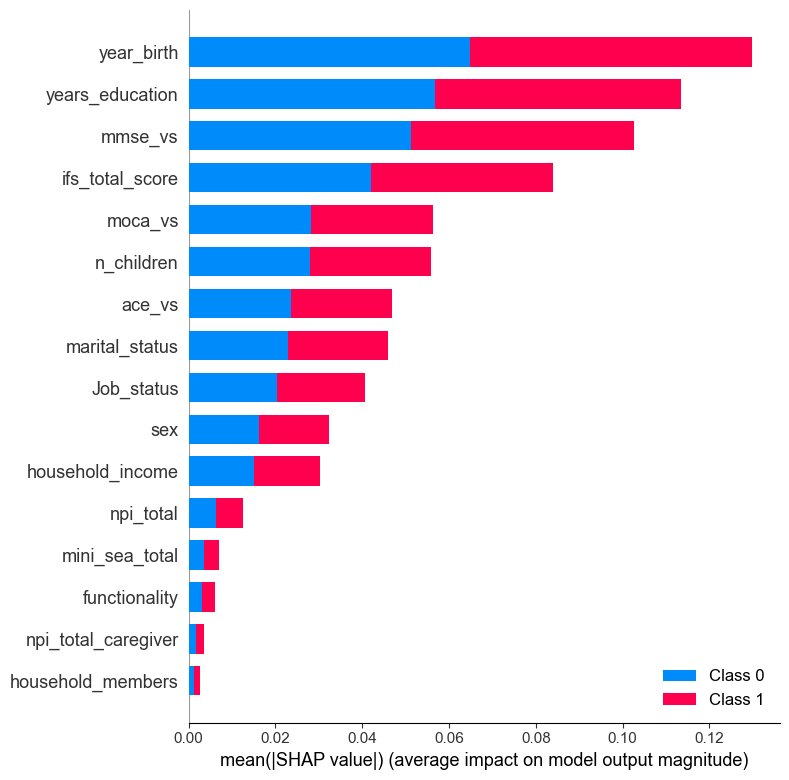

In [188]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

In [189]:
# xgb_sfe_cols = xgb_sfe_cols + ['diagnosis']

#### Bootstrap

In [190]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 5000/5000 [11:04<00:00,  7.52it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:11.076756898562113 minutes
empirical p-value: 0.0


In [191]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.836672
ROC_AUC        0.854406
Precision      0.708095
Recall         0.531157
Sensitivity    0.531157
Specificity    0.930992
F1             0.603982
Efron_pR2      0.342721
dtype: float64

In [192]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
14,year_birth,37.357200,5.084248,7.022965,1.060888
5,ifs_total_score,27.270400,4.038434,11.475726,1.956286
1,ace_vs,22.124400,5.336986,7.153567,1.845506
15,years_education,21.472000,3.903673,3.498435,0.591765
9,moca_vs,15.865800,4.467189,2.204741,0.485799
11,npi_total,13.422000,3.027961,2.470840,0.445883
6,marital_status,7.699600,1.799113,6.513011,1.631428
2,functionality,6.980711,2.900138,2.323624,0.695980
8,mmse_vs,5.880226,2.897229,2.847977,1.341740
13,sex,5.379019,2.111998,2.213601,0.573871


In [193]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010247,0.009776,0.012602,0.013832,0.013832,0.007026,0.013556,0.013156


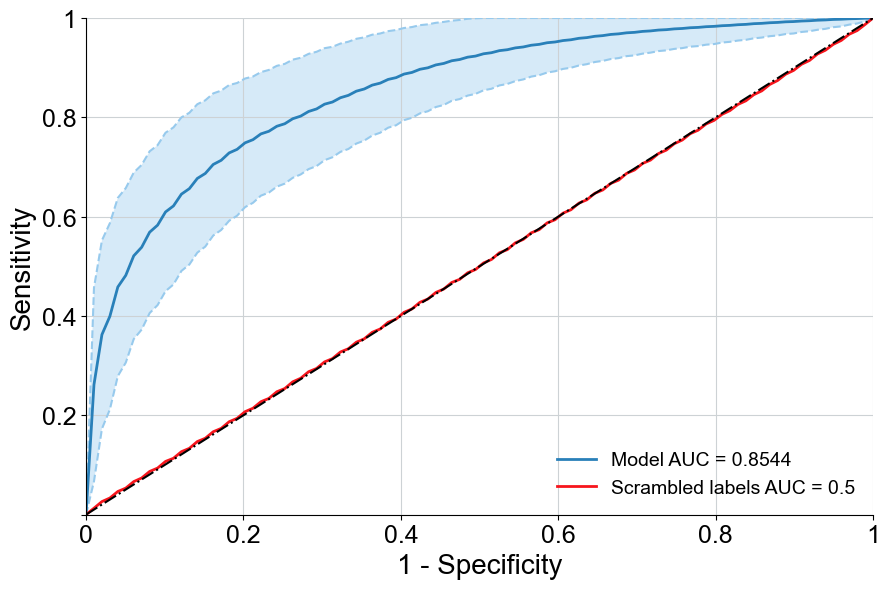

In [194]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

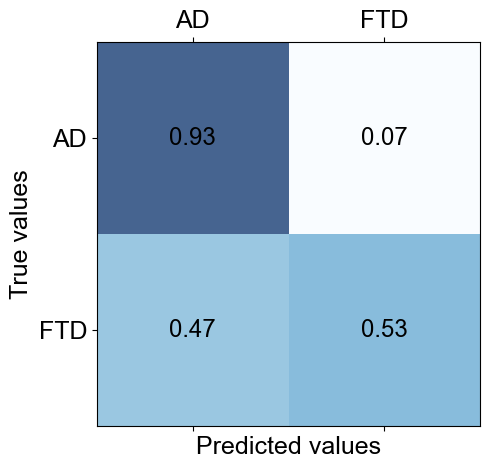

In [195]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [196]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

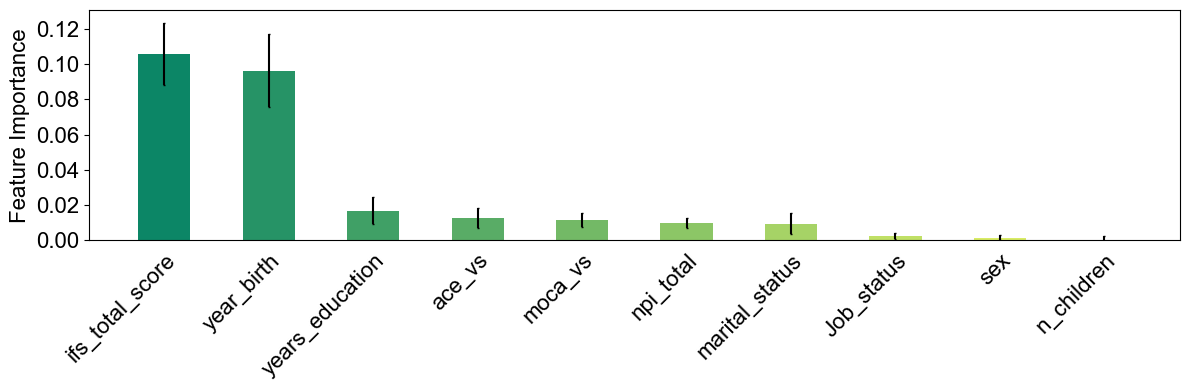

In [197]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [198]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,Job_status,2.206914,1.192727,4.392391,2.210073
1,ace_vs,22.124400,5.336986,7.153567,1.845506
2,functionality,6.980711,2.900138,2.323624,0.695980
3,household_income,1.527814,0.732155,3.644097,1.417029
4,household_members,1.000000,0.000000,8.188339,1.483100
5,ifs_total_score,27.270400,4.038434,11.475726,1.956286
6,marital_status,7.699600,1.799113,6.513011,1.631428
7,mini_sea_total,2.959292,1.442064,1.660247,0.792470
8,mmse_vs,5.880226,2.897229,2.847977,1.341740
9,moca_vs,15.865800,4.467189,2.204741,0.485799


In [199]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
14,year_birth,37.357200,5.084248,7.022965,1.060888
5,ifs_total_score,27.270400,4.038434,11.475726,1.956286
1,ace_vs,22.124400,5.336986,7.153567,1.845506
15,years_education,21.472000,3.903673,3.498435,0.591765
9,moca_vs,15.865800,4.467189,2.204741,0.485799
11,npi_total,13.422000,3.027961,2.470840,0.445883
6,marital_status,7.699600,1.799113,6.513011,1.631428
2,functionality,6.980711,2.900138,2.323624,0.695980
8,mmse_vs,5.880226,2.897229,2.847977,1.341740
13,sex,5.379019,2.111998,2.213601,0.573871


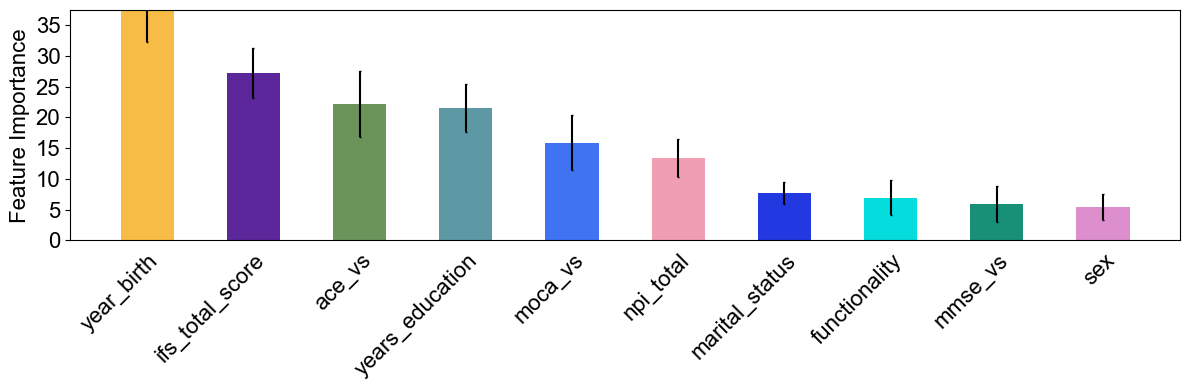

In [200]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

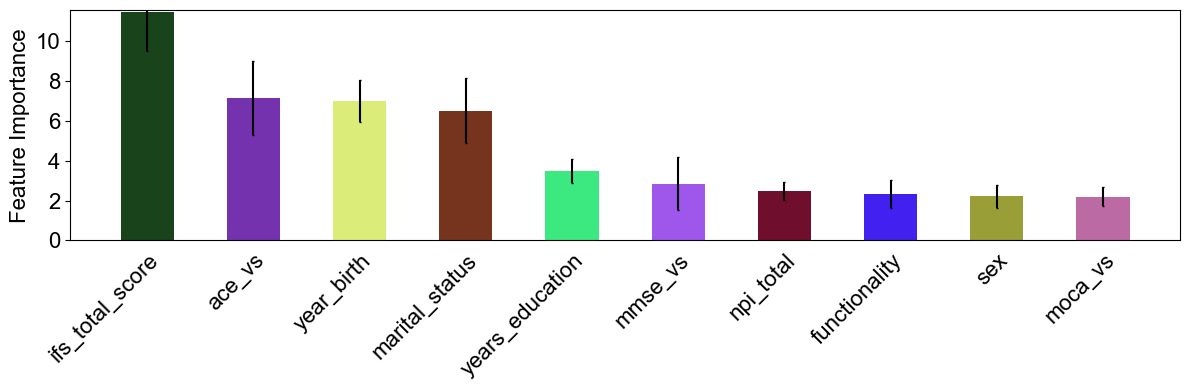

In [201]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [202]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [203]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [204]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.8078
Accuracy: 0.8972
Recall: 0.64
F1: 0.7442
Precision:0.8889

Unseen Data ROC score: 		0.8078
Bootstrping test ROC score: 	0.8544


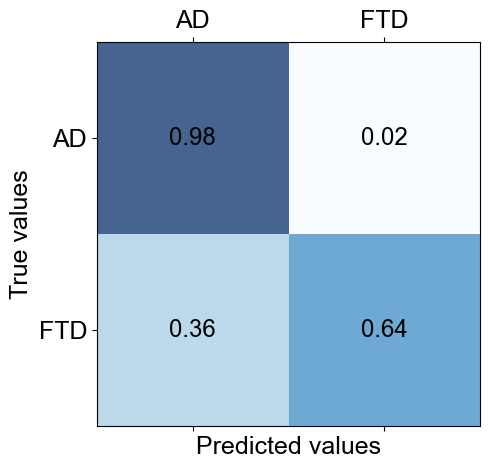

In [205]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM_unseen.png")

#### Shapley

In [206]:
# # compute SHAP values
explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


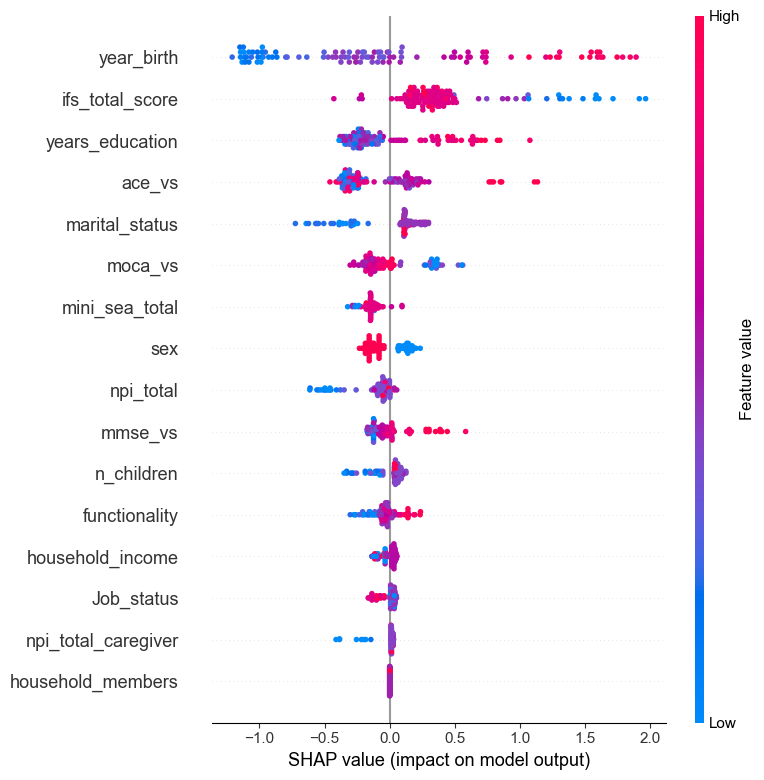

In [207]:
shap.summary_plot(shap_values, feature_names=X_unseen.columns)

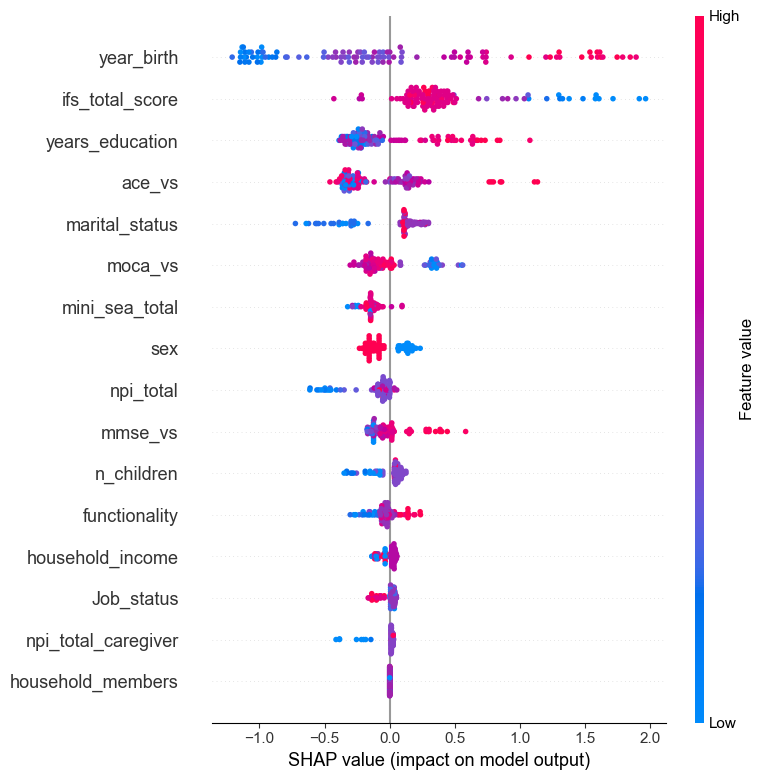

In [208]:
shap.summary_plot(shap_values)

In [209]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [210]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [211]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [212]:
rf_params['max_features'] =1

In [226]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [227]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    2.2s remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.6s finished
Features: 1/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.1s finished
Features: 2/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    2.2s finished
Features: 3/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.2s finished
Features: 4/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  12 

In [228]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [229]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.7507692307692307, 0.7446153846153846, 0.780...",0.75875,"(ifs_total_score,)",0.035641,0.015838,0.011199
2,"(3, 13)","[0.7630769230769231, 0.796923076923077, 0.8024...",0.78749,"(ifs_total_score, household_members)",0.039179,0.01741,0.012311
3,"(3, 6, 13)","[0.7784615384615384, 0.8153846153846154, 0.830...",0.808031,"(ifs_total_score, npi_total_caregiver, househo...",0.048993,0.021771,0.015395
4,"(3, 6, 9, 13)","[0.7907692307692308, 0.8092307692307692, 0.820...",0.806996,"(ifs_total_score, npi_total_caregiver, ace_vs,...",0.027988,0.012437,0.008795
5,"(3, 4, 6, 9, 13)","[0.796923076923077, 0.8153846153846154, 0.8271...",0.813156,"(ifs_total_score, mini_sea_total, npi_total_ca...",0.028004,0.012445,0.0088
6,"(3, 4, 5, 6, 9, 13)","[0.7907692307692308, 0.8215384615384616, 0.827...",0.813156,"(ifs_total_score, mini_sea_total, npi_total, n...",0.035995,0.015995,0.01131
7,"(3, 4, 5, 6, 9, 13, 15)","[0.7876923076923077, 0.8246153846153846, 0.824...",0.812127,"(ifs_total_score, mini_sea_total, npi_total, n...",0.038885,0.01728,0.012218
8,"(1, 3, 4, 5, 6, 9, 13, 15)","[0.796923076923077, 0.8184615384615385, 0.8209...",0.812124,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.024299,0.010798,0.007635
9,"(1, 3, 4, 5, 6, 9, 10, 13, 15)","[0.8, 0.8276923076923077, 0.8179012345679012]",0.815198,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.025802,0.011466,0.008108
10,"(1, 3, 4, 5, 6, 9, 10, 12, 13, 15)","[0.7846153846153846, 0.8153846153846154, 0.827...",0.809053,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.040363,0.017937,0.012683


In [230]:
sfs_rf.loc[[5],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
5,"(3, 4, 6, 9, 13)","[0.796923076923077, 0.8153846153846154, 0.8271...",0.813156,"(ifs_total_score, mini_sea_total, npi_total_ca...",0.028004,0.012445,0.0088


In [231]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])

In [232]:
sfs_rf_features

['ifs_total_score',
 'mini_sea_total',
 'npi_total_caregiver',
 'ace_vs',
 'household_members']

In [220]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

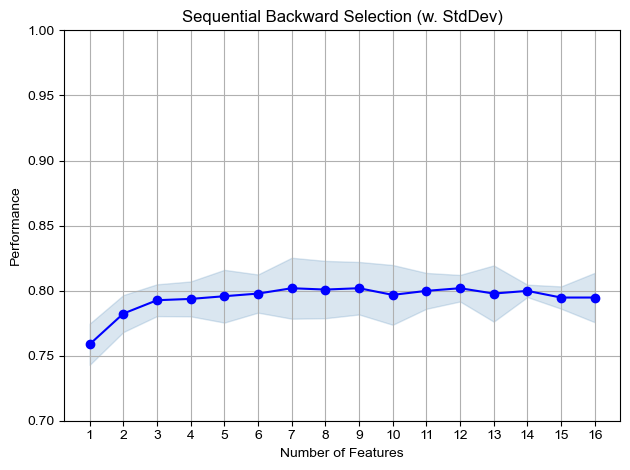

In [221]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [222]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


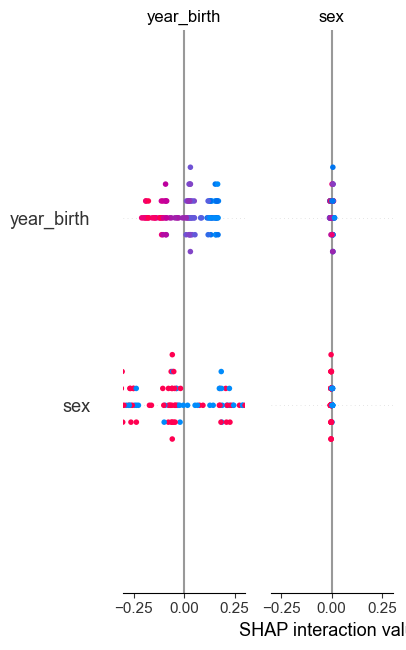

In [223]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

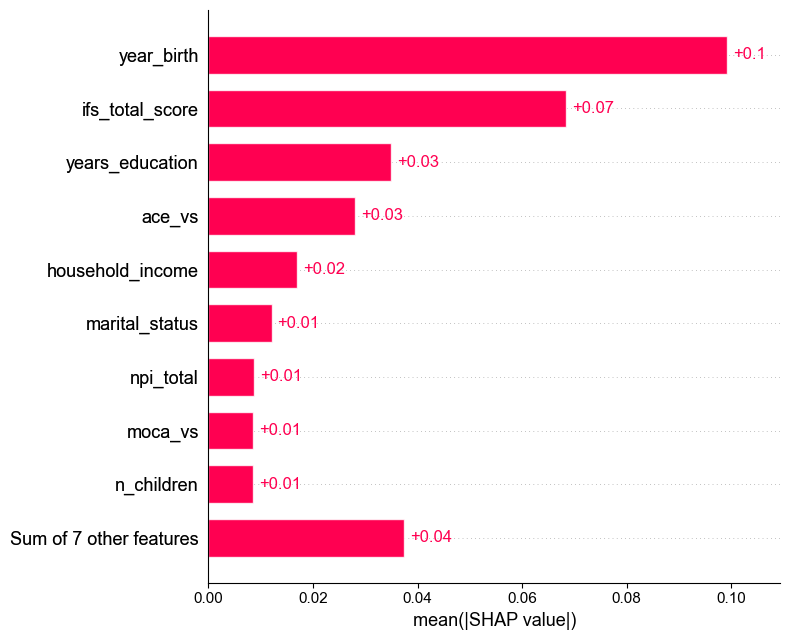

In [224]:
shap.plots.bar(shap_values[:,:,1])

#### RF with SFS

In [242]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data[sfs_rf_features + ['diagnosis']], 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       min_samples_leaf=0.01, min_samples_split=0.01,
                       n_estimators=309, n_jobs=-1)


Iterating: 100%|██████████████████| 5000/5000 [57:47<00:00,  1.44it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:57.79132851362228 minutes
empirical p-value: 0.0


In [243]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-25/mean_res'

In [244]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res_sfs.csv", index=False)
Model_res.mean()

Accuracy       0.793923
ROC_AUC        0.806993
Precision      0.555474
Recall         0.658952
Sensitivity    0.658952
Specificity    0.835592
F1             0.601204
Efron_pR2      0.023683
dtype: float64

In [245]:
print("%.4f" % Model_res['ROC_AUC'].mean())

0.8070


In [246]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df_sfs.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.011212,0.010939,0.013774,0.01314,0.01314,0.010274,0.013572,0.004215


In [247]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r_sfs.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)


,variables,Importance_mean,Importance_std
2,ifs_total_score,0.407794,0.021186
0,ace_vs,0.275697,0.020651
3,mini_sea_total,0.120814,0.011493
1,household_members,0.103454,0.012349
4,npi_total_caregiver,0.092241,0.010142


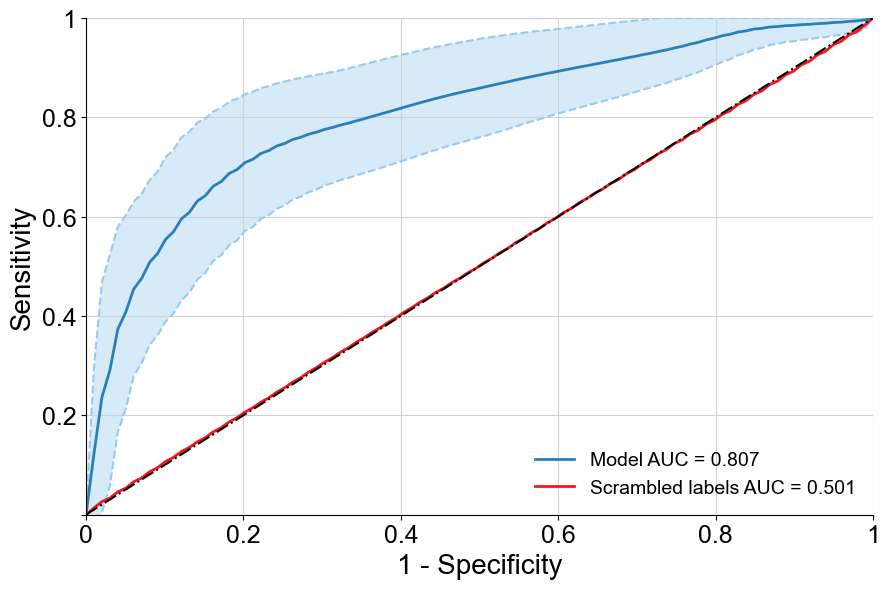

In [248]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve_sfs.png")
# Fig save?

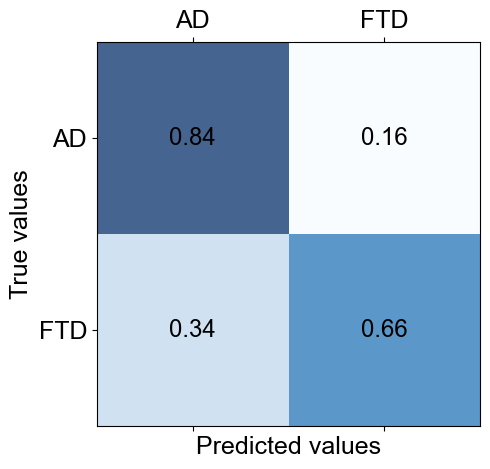

In [249]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM_sfs.png")

##### Permutation Feature importance

In [264]:
rf_fimp = bc.permutation_FIMP(data[sfs_rf_features + ['diagnosis']], 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [265]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI_sfs.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [266]:
top_10p.head()

,predictor,mean,std
0,ifs_total_score,0.218205,0.035729
3,ace_vs,0.080882,0.017689
2,npi_total_caregiver,0.025057,0.009759
1,mini_sea_total,0.006346,0.009283
4,household_members,0.004705,0.012139


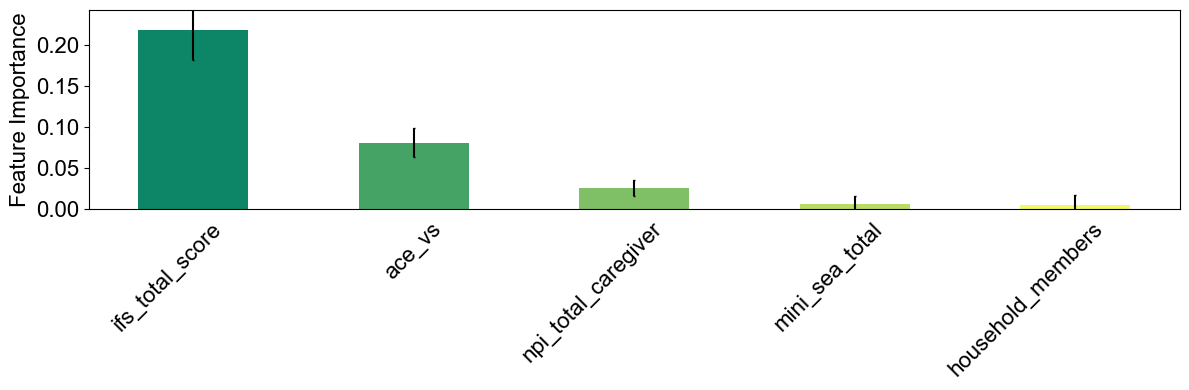

In [267]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [268]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
2,ifs_total_score,0.407794,0.021186
0,ace_vs,0.275697,0.020651
3,mini_sea_total,0.120814,0.011493
1,household_members,0.103454,0.012349
4,npi_total_caregiver,0.092241,0.010142


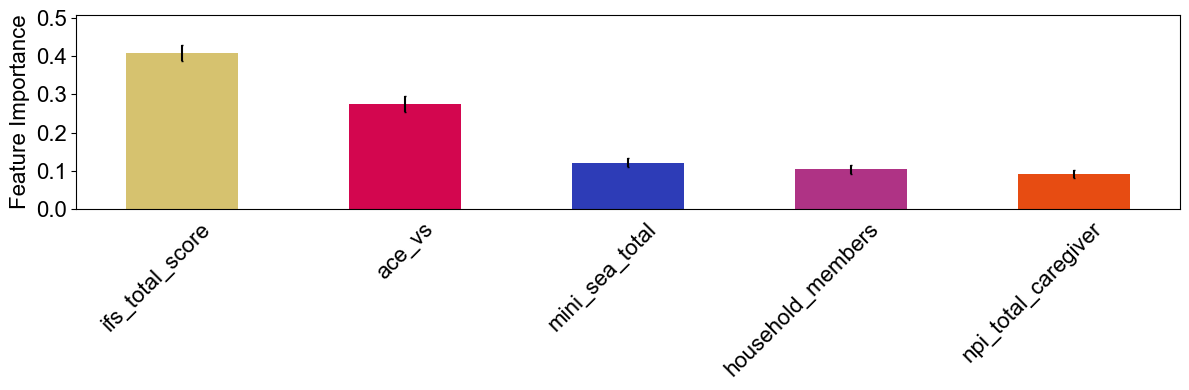

In [269]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

In [270]:
X_train = X_train[sfs_rf_features]
X_unseen = X_unseen[sfs_rf_features]

In [271]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [272]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen_sfs.csv")

In [273]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6607
Accuracy: 0.757
Recall: 0.48
F1: 0.48
Precision:0.48
Unseen Data ROC score: 		0.6607
Bootstrping test ROC score: 	0.8070


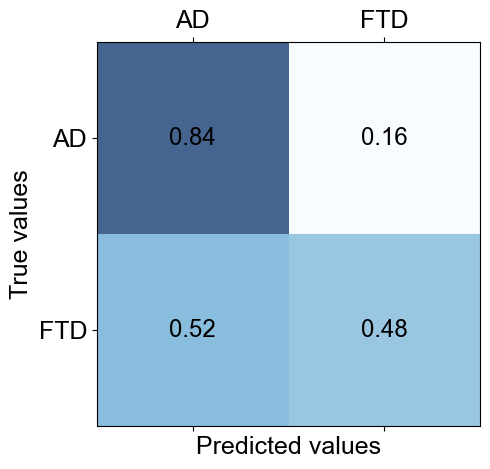

In [274]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM_unseen_sfs.png")

##### Shapley

In [275]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


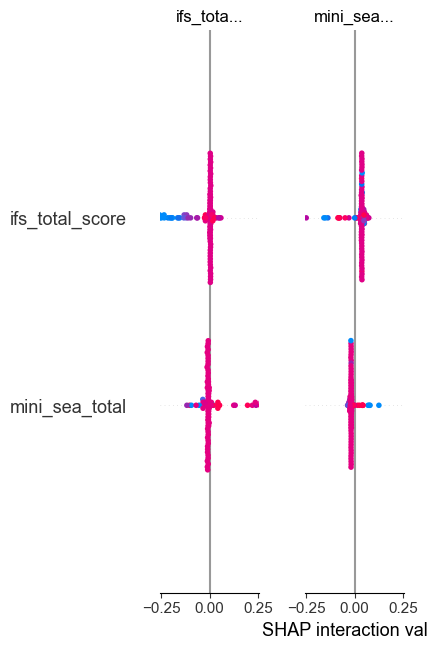

In [276]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

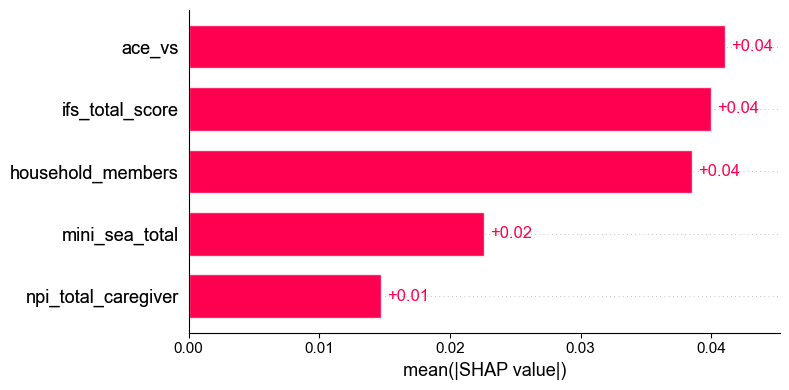

In [277]:
shap.plots.bar(shap_values[:,:,1])

In [281]:
post = pd.read_csv(data_path+"train.csv")

In [282]:
post.groupby('diagnosis')['mini_sea_total'].mean()

diagnosis
AD     20.708110
CN     25.206319
FTD    19.074053
Name: mini_sea_total, dtype: float64

In [283]:
post.groupby('diagnosis')['mini_sea_total'].median()

diagnosis
AD     21.000
CN     26.000
FTD    20.571
Name: mini_sea_total, dtype: float64